## 뉴스 데이터 감정 레이블 예측

In [1]:
import pandas as pd
import numpy as np
from transformers import TFBertForSequenceClassification, BertTokenizer

---
### 뉴스 감정 분석 모델 적용
- `뉴스 감정 데이터 셋`과 `KLUE BERT`모델을 사용하여 학습시킨 `sentiment_analysis_model` 모델 적용

In [2]:
# 뉴스 감정 분석 모델과 토크나이저 불러오기
MODEL_PATH = "../subject_focus_finetuned_model"  # 모델이 저장된 경로
MODEL_NAME = "klue/bert-base"  # 모델 이름

tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = TFBertForSequenceClassification.from_pretrained(MODEL_PATH)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../subject_focus_finetuned_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


---
### 네이버 뉴스 크롤링 데이터 전처리
- 네이버 뉴스 API사용하여 `SK하이닉스` 키워드로 검색된 뉴스 데이터
- 한 번에 요청할 수 있는 데이터가 1000개 이므로 `AWS 리눅스 서버`를 통한 `crontab 스케줄러`로 1시간 마다 API요청을 스케줄링하여 데이터 수집
- 데이터 건수: 8681건
- 데이터 기간: 2024_11_04_09:00 ~ 2024_11_27_18:00
- 컬럼: `pub_date(%Y_%m_%d_%H:%S)`, `title`, `description`
- 뉴스 감정 특성상 뉴스 내용이 중복되거나 비슷한 뉴스가 존재하나,
이 또한 해당 뉴스 내용에 대한 이슈도라고 생각하여 중복 제거를 하지 않음.

In [3]:
# 네이버 뉴스 크롤링 데이터 불러오기
news_data = pd.read_csv('../data/naver_news_crawling_data.csv', header=None, names=['pub_date', 'title', 'description'])

- 결측값 제거: 수집과정에서 `description`컬럼의 값이 누락 된 2개의 데이터 제거
- `title`컬럼 제거
- `pub_data`, `description` 컬럼의 형식을 변환
- 데이터를 BERT 모델에 적합한 형태로 변환

In [4]:
# 데이터 셋 요약 확인
print('데이터 요약')
news_data.info()

# 결측값 확인
print('\n결측값 여부 :',news_data.isnull().values.any(), '\n')

# 'description' 컬럼에서 결측치 제거
news_data = news_data.dropna(subset=['description'])

# 'title' 컬럼(뉴스 제목) 제거
news_data = news_data.drop(columns=['title'])

# 'pub_date' 컬럼을 datetime 형식으로 변환
news_data['pub_date'] = pd.to_datetime(news_data['pub_date'], format='%Y_%m_%d_%H:%S', errors='coerce')

# 'description' 컬럼을 문자열 형식으로 변환
news_data['description'] = news_data['description'].astype(str)

# "SK하이닉스", "sk하이닉스" 텍스트 변환
news_data = news_data.applymap(lambda x: x.replace("SK하이닉스", "<SK하이닉스>") if isinstance(x, str) else x)
news_data = news_data.applymap(lambda x: x.replace("sk하이닉스", "<SK하이닉스>") if isinstance(x, str) else x)

# 데이터 셋 요약 확인
print('데이터 요약')
news_data.info()

print('\n총 데이터 수 :',len(news_data))

# 데이터 전처리 (BERT 모델 입력에 맞게 텍스트를 인코딩)
def encode_data(data):
    return tokenizer(
        data['description'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )

# 데이터 전처리
encodings = encode_data(news_data)

데이터 요약
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9694 entries, 0 to 9693
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pub_date     9694 non-null   object
 1   title        9694 non-null   object
 2   description  9692 non-null   object
dtypes: object(3)
memory usage: 227.3+ KB

결측값 여부 : True 

데이터 요약
<class 'pandas.core.frame.DataFrame'>
Index: 9692 entries, 0 to 9693
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pub_date     9692 non-null   datetime64[ns]
 1   description  9692 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 227.2+ KB

총 데이터 수 : 9692


---
### 감정 레이블 예측
- `description`컬럼을 대상으로 감정 레이블을 예측 (0:neutral ,1:positive ,2:negative)
- 예측한 감정 레이블을 데이터프레임에 추가하고 새로운 데이터를 CSV파일로 저장

In [5]:
# 예측 실행
predictions = model.predict(encodings['input_ids'])
predicted_classes = np.argmax(predictions.logits, axis=1)

303/303 [==============================] - 59s 174ms/step


'중립'감정 데이터
                pub_date                                        description  \
9689 2024-11-30 10:00:00  김경희 이천시장과 임해규 두원공대 총장이 말하는 반도체 산업의 속살 첨단과 전통 도...   
9692 2024-11-30 12:00:00  트레이닝복세면도구속옷 등으로 구성된 구호키트와 대피소 칸막이는 <SK하이닉스>의 기...   
9693 2024-11-30 13:00:00  이 종목은 <SK하이닉스>103 일본 반도체 장비주 어드반테스트96 대만 TSMC8...   

      sentiment  
9689          0  
9692          0  
9693          0  


'긍정'감정 데이터
                pub_date                                        description  \
9661 2024-11-30 00:00:00  이 산업의 대표적인 수혜자가 최고 성능의 5세대 HBM인 HBM3E 양산에 성공 엔...   
9672 2024-11-30 07:00:00  반면 인공지능AI 시장이 개화하며 HBM 수요가 크게 늘었고 <SK하이닉스> 등 메...   
9687 2024-11-30 10:00:00  국내 대표적 인공지능AI 붐 수혜기업으로 꼽히는 <SK하이닉스>와 관련 최태원 SK...   

      sentiment  
9661          1  
9672          1  
9687          1  


'부정'감정 데이터
                pub_date                                        description  \
9685 2024-11-30 06:00:00  미국 정부효율부 수장 임명자가 반도체과학법칩스법에 따른 반도체 보조금 지급 전반을 ...   
9690 2024-11-30 10:00:00  추

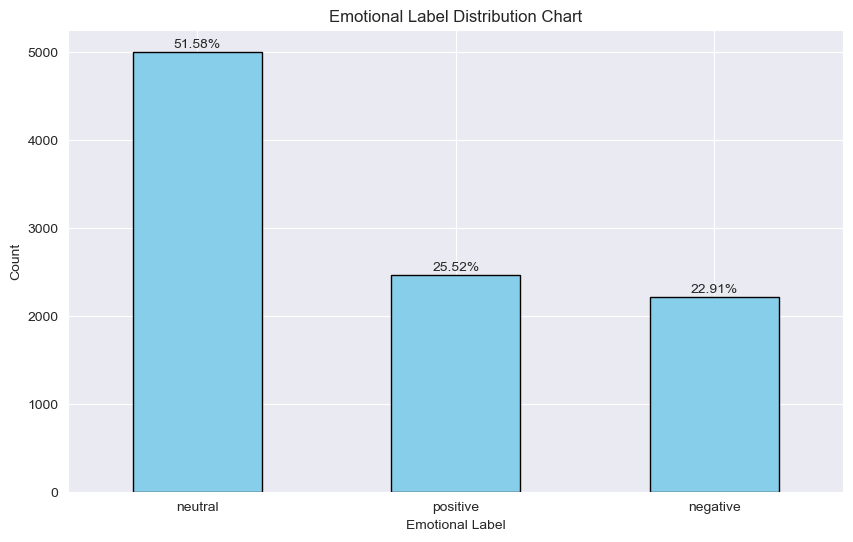

In [6]:

import matplotlib.pyplot as plt

# 예측된 감정 레이블을 데이터프레임에 추가
news_data['sentiment'] = predicted_classes

for label in range(3):
    if label == 0:
        sentiment = '중립'
    elif label == 1:
        sentiment = '긍정'
    else:
        sentiment = '부정' 
    
    print(f"'{sentiment}'감정 데이터")
    print(news_data[news_data['sentiment'] == label].tail(3))
    print("\n")

# 예측된 결과를 새로운 CSV 파일로 저장
news_data.to_csv('../data/naver_news_crawling_data_with_sentiment.csv', index=False)

# 라벨 분포 시각화
plt.figure(figsize=(10, 6))
label_counts = news_data['sentiment'].value_counts()
label_counts = label_counts.loc[[0, 1, 2]].fillna(0).astype(int)
bar_plot = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('Emotional Label Distribution Chart')
plt.xlabel('Emotional Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['neutral', 'positive', 'negative'], rotation=0)
# 비율 표기
total = label_counts.sum()
for i, value in enumerate(label_counts):
    percentage = (value / total) * 100
    plt.text(i, value + 10, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10)